In [ ]:
import pandas as pd

# Load the CSV file
file_path = '/content/Stock.csv'
df = pd.read_csv(file_path)

# show basic info
print("Dataset shape:", df.shape)
print("\nColumn names:\n", df.columns.tolist())
print("\nFirst 5 rows:")
df.head()


Dataset shape: (944, 7)

Column names:
 ['date', 'open', 'high', 'low', 'close', 'volume', 'Name']

First 5 rows:


,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [ ]:
# Convert 'date' column to datetime type
df['date'] = pd.to_datetime(df['date'])

# Sort the dataset by stock name and date
df = df.sort_values(by=['Name', 'date']).reset_index(drop=True)

# show the changes
print(df.dtypes)
df.head()


date      datetime64[ns]
open             float64
high             float64
low              float64
close            float64
volume             int64
Name              object
dtype: object


,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [ ]:
# Calculating daily return for each stock
df['daily_return'] = df.groupby('Name')['close'].pct_change()

# show updated dataset
df[['date', 'Name', 'close', 'daily_return']].head(10)


,date,Name,close,daily_return
0,2013-02-08,AAL,14.75,NaN
1,2013-02-11,AAL,14.46,-0.019661
2,2013-02-12,AAL,14.27,-0.013140
3,2013-02-13,AAL,14.66,0.027330
4,2013-02-14,AAL,13.99,-0.045703
5,2013-02-15,AAL,14.50,0.036455
6,2013-02-19,AAL,14.26,-0.016552
7,2013-02-20,AAL,13.33,-0.065217
8,2013-02-21,AAL,13.37,0.003001
9,2013-02-22,AAL,13.57,0.014959


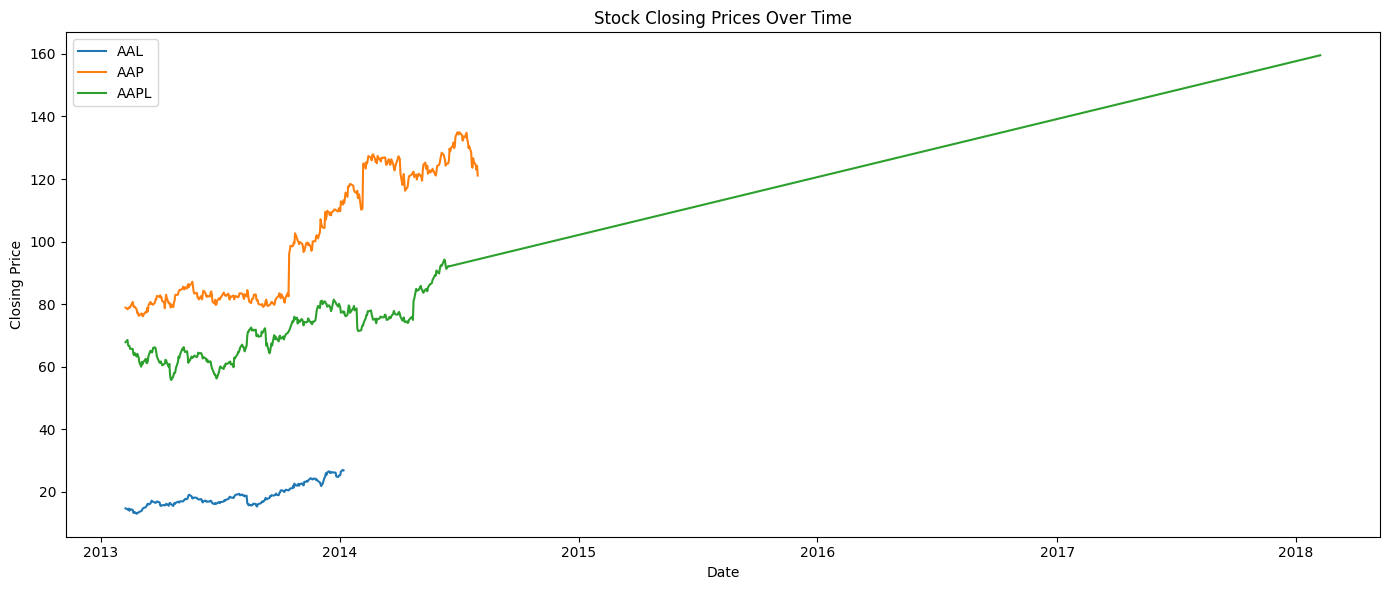

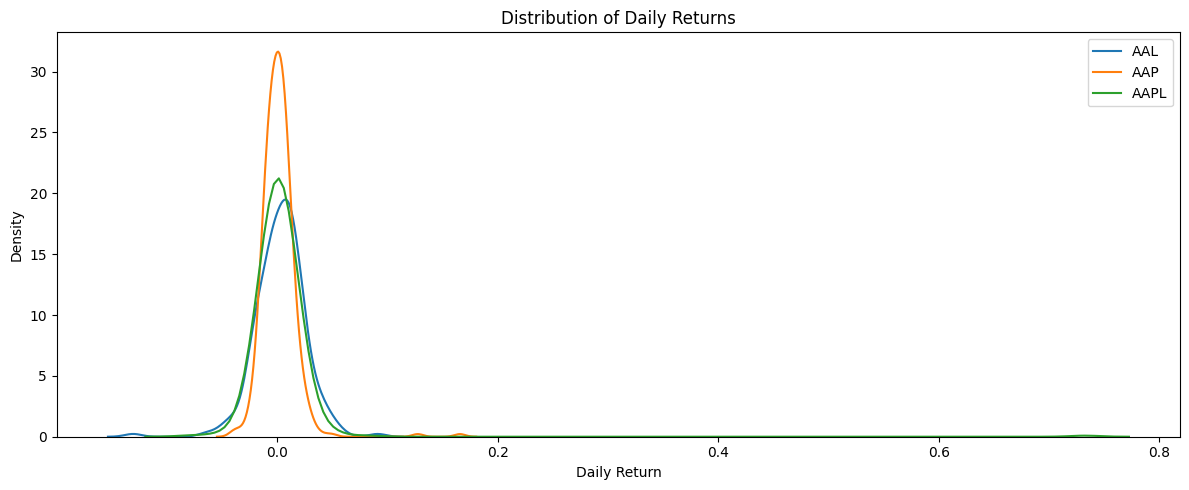

In [ ]:
#visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Plot closing price trends for each stock
plt.figure(figsize=(14, 6))
for name in df['Name'].unique():
    subset = df[df['Name'] == name]
    plt.plot(subset['date'], subset['close'], label=name)

plt.title('Stock Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.tight_layout()
plt.show()

# Plot daily return distributions
plt.figure(figsize=(12, 5))
for name in df['Name'].unique():
    sns.kdeplot(df[df['Name'] == name]['daily_return'].dropna(), label=name)

plt.title('Distribution of Daily Returns')
plt.xlabel('Daily Return')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
#Portfolio construction and return analysis
import numpy as np

# Pivot the data Rows = Dates, Columns = Stocks, Values = Daily Returns
pivot_returns = df.pivot(index='date', columns='Name', values='daily_return')

# Drop missing values
pivot_returns = pivot_returns.dropna()

# Assign equal weights to each stock
num_stocks = len(pivot_returns.columns)
weights = np.array([1/num_stocks] * num_stocks)

# Calculate average daily return per stock
mean_daily_returns = pivot_returns.mean()

# Calculate expected portfolio return
expected_portfolio_return = np.dot(mean_daily_returns, weights)

# Calculate portfolio volatility
cov_matrix = pivot_returns.cov()
portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

print("Expected Daily Return of Portfolio:", round(expected_portfolio_return * 100, 2), "%")
print("Portfolio Daily Risk (Volatility):", round(portfolio_volatility * 100, 2), "%")


Expected Daily Return of Portfolio: 0.18 %
Portfolio Daily Risk (Volatility): 1.12 %


In [ ]:
#calculate sharp ratio
# Define a risk-free rate (can use 0.01 for 1% annually, divide by 252 for daily)
risk_free_rate = 0.01 / 252

# Calculate Sharpe Ratio (daily)
sharpe_ratio = (expected_portfolio_return - risk_free_rate) / portfolio_volatility

print("Sharpe Ratio (Daily):", round(sharpe_ratio, 2))


Sharpe Ratio (Daily): 0.15


In [ ]:


# Simple Investment Recommendation based on Sharpe Ratio
if sharpe_ratio > 1:
    print(" Portfolio is performing well with good risk-adjusted return.")
elif sharpe_ratio > 0.5:
    print(" Portfolio has moderate performance. Consider optimizing weights.")
else:
    print(" Portfolio risk-adjusted performance is poor. Reevaluate your strategy.")


 Portfolio risk-adjusted performance is poor. Reevaluate your strategy.


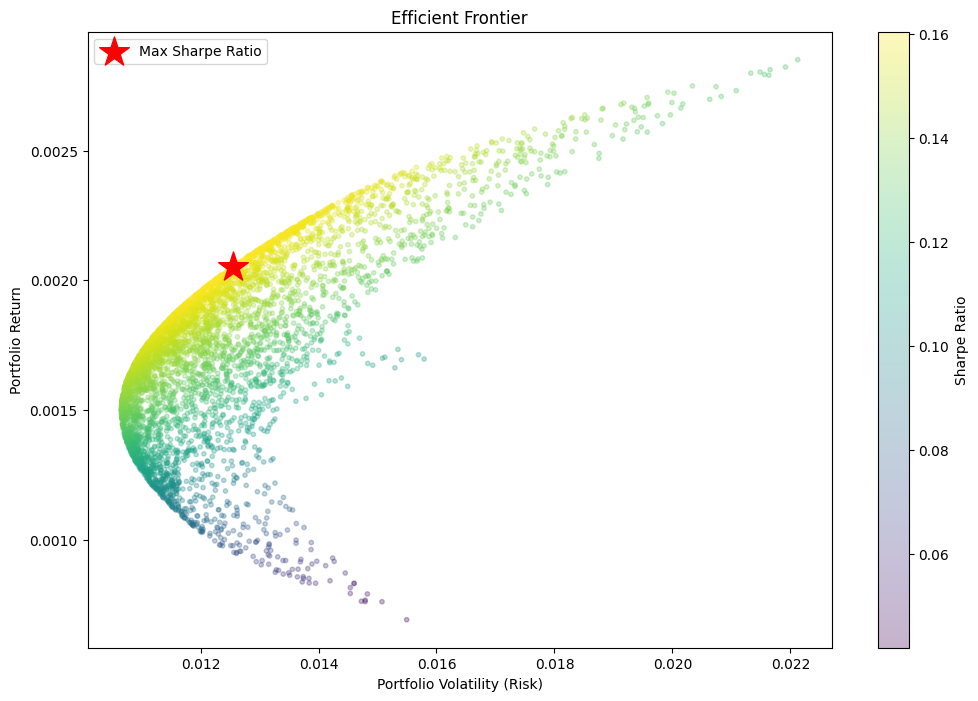

In [ ]:
#Visualizing Portfolio Risk vs Return plots
import matplotlib.pyplot as plt

# Number of random portfolios to simulate
num_portfolios = 5000

# Arrays to store simulation results
results = np.zeros((3, num_portfolios))

for i in range(num_portfolios):
    # Random weights that sum to 1
    weights = np.random.random(num_stocks)
    weights /= np.sum(weights)

    # Portfolio return and volatility
    port_return = np.dot(mean_daily_returns, weights)
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

    # Store results(Return, Volatility, Sharpe Ratio)
    results[0,i] = port_return
    results[1,i] = port_volatility
    results[2,i] = (port_return - risk_free_rate) / port_volatility

# Extract the portfolio with the max Sharpe Ratio
max_sharpe_idx = np.argmax(results[2])
max_sharpe_return = results[0, max_sharpe_idx]
max_sharpe_volatility = results[1, max_sharpe_idx]

# Plot all portfolios
plt.figure(figsize=(12,8))
plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='viridis', marker='o', s=10, alpha=0.3)
plt.colorbar(label='Sharpe Ratio')

# Highlight max Sharpe Ratio portfolio
plt.scatter(max_sharpe_volatility, max_sharpe_return, marker='*', color='r', s=500, label='Max Sharpe Ratio')

plt.title('Efficient Frontier')
plt.xlabel('Portfolio Volatility (Risk)')
plt.ylabel('Portfolio Return')
plt.legend()
plt.show()


In [ ]:
#recomandation  of investment and portfolio optimization
# Best portfolio weights (max Sharpe)
best_weights = np.random.random(num_stocks)
best_weights /= np.sum(best_weights)  # Ensure sum to 1

# To retrieve the exact weights for max Sharpe Ratio portfolio from simulation,
# we must save weights in the loop. Let's modify previous loop for this-

# (If you have not saved weights before, rerun this adjusted simulation)
num_portfolios = 5000
results = np.zeros((3, num_portfolios))
weights_record = []

for i in range(num_portfolios):
    weights = np.random.random(num_stocks)
    weights /= np.sum(weights)
    weights_record.append(weights)

    port_return = np.dot(mean_daily_returns, weights)
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

    results[0,i] = port_return
    results[1,i] = port_volatility
    results[2,i] = (port_return - risk_free_rate) / port_volatility

max_sharpe_idx = np.argmax(results[2])
optimal_weights = weights_record[max_sharpe_idx]

print("Optimal Portfolio Weights:")
for stock, weight in zip(pivot_returns.columns, optimal_weights):
    print(f"{stock}: {weight*100:.2f}%")

print("\nInvestment Recommendation:")
print("Allocate your investments according to the above weights for the best risk-adjusted return portfolio.")


Optimal Portfolio Weights:
AAL: 40.96%
AAP: 45.55%
AAPL: 13.49%

Investment Recommendation:
Allocate your investments according to the above weights for the best risk-adjusted return portfolio.


----- Final Portfolio Summary -----
Expected Daily Return: 0.20%
Portfolio Volatility (Risk): 1.25%
Sharpe Ratio: 0.16



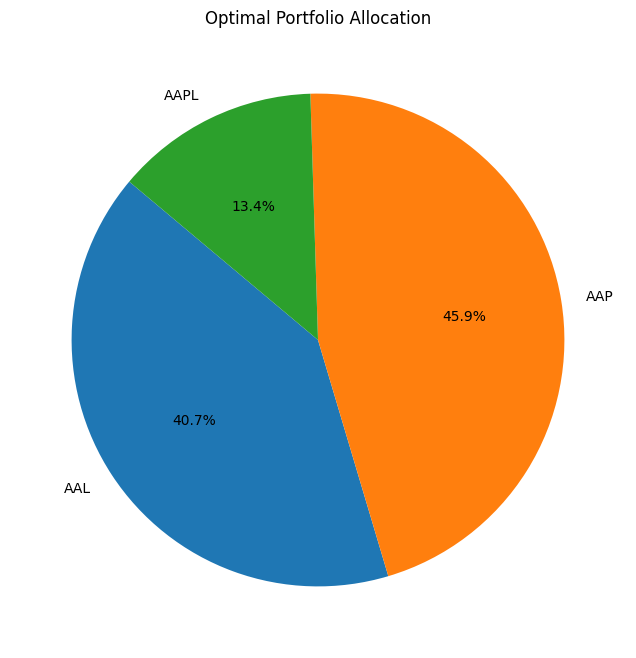

In [ ]:
#final visulization
# Summary metrics for optimal portfolio
opt_return = results[0][max_sharpe_idx]
opt_volatility = results[1][max_sharpe_idx]
opt_sharpe = results[2][max_sharpe_idx]

print("----- Final Portfolio Summary -----")
print(f"Expected Daily Return: {opt_return*100:.2f}%")
print(f"Portfolio Volatility (Risk): {opt_volatility*100:.2f}%")
print(f"Sharpe Ratio: {opt_sharpe:.2f}\n")

# Pie chart of portfolio allocation
plt.figure(figsize=(8, 8))
plt.pie(optimal_weights, labels=pivot_returns.columns, autopct='%1.1f%%', startangle=140)
plt.title('Optimal Portfolio Allocation')
plt.show()


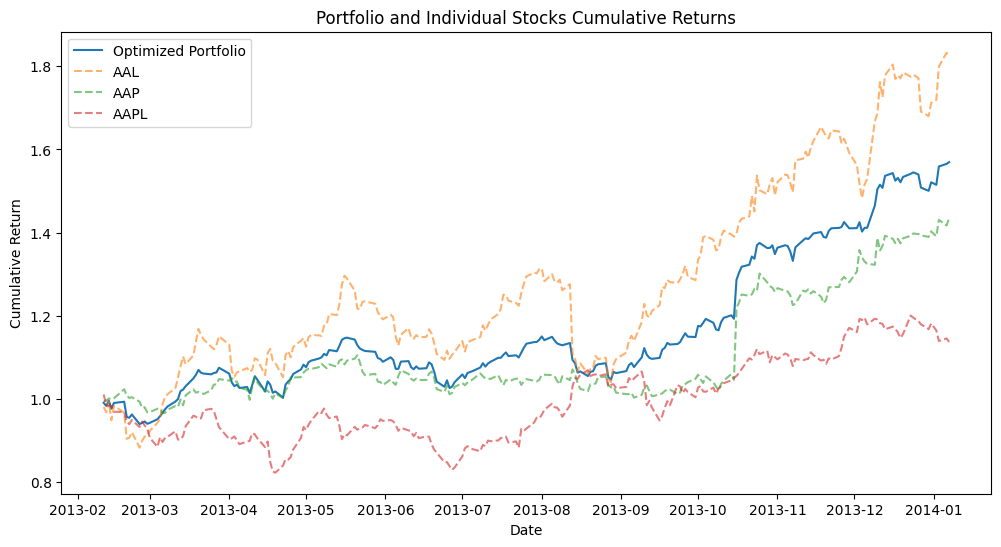

In [ ]:
# Calculate daily portfolio returns using optimal weights
portfolio_returns = pivot_returns.dot(optimal_weights)

# Calculate cumulative returns
cumulative_returns = (1 + portfolio_returns).cumprod()

# Plot cumulative returns over time
plt.figure(figsize=(12,6))
plt.plot(cumulative_returns.index, cumulative_returns, label='Optimized Portfolio')

# Optional: plot individual stocks for comparison
for stock in pivot_returns.columns:
    plt.plot((1 + pivot_returns[stock]).cumprod(), linestyle='--', alpha=0.6, label=stock)

plt.title('Portfolio and Individual Stocks Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()

#(Calculate cumulative return ove time
#plotting growth of portfolio based on history)

In [ ]:
!pip install reportlab
# for report

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 17.8 MB/s eta 0:00:00


In [ ]:
# trying to generate pdf or report
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
from reportlab.platypus import Image
import matplotlib.pyplot as plt

#Save your charts as images
plt.figure(figsize=(12,6))
plt.plot(cumulative_returns.index, cumulative_returns, label='Optimized Portfolio')
for stock in pivot_returns.columns:
    plt.plot((1 + pivot_returns[stock]).cumprod(), linestyle='--', alpha=0.6, label=stock)
plt.title('Portfolio and Individual Stocks Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.tight_layout()
plt.savefig("cumulative_returns.png")
plt.close()

#  Create PDF report
pdf_file = "Portfolio_Report.pdf"
c = canvas.Canvas(pdf_file, pagesize=letter)
width, height = letter

# Title
c.setFont("Helvetica-Bold", 20)
c.drawCentredString(width/2, height - 50, "Investment Portfolio Analysis Report")

# Portfolio metrics summary
c.setFont("Helvetica", 12)
text = f"""
Expected Daily Return: {expected_portfolio_return * 100:.2f}%
Portfolio Daily Volatility: {portfolio_volatility * 100:.2f}%
Sharpe Ratio (Daily): {sharpe_ratio:.2f}
"""
text_lines = text.strip().split('\n')
y = height - 100
for line in text_lines:
    c.drawString(50, y, line)
    y -= 20

# Insert cumulative returns plot
c.drawImage("cumulative_returns.png", 50, y - 300, width=500, height=300)

c.showPage()
c.save()

print(f"PDF report '{pdf_file}' generated successfully.")


PDF report 'Portfolio_Report.pdf' generated successfully.


In [ ]:
# I have done  follwinf things in this project
#Loading and cleaning real financial data
#Calculating and analyzing daily returns
#Visualizing stock trends and returns
#Building a simple portfolio with equal weights
#Calculating portfolio expected return, risk (volatility)
#Computing Sharpe ratio for risk-adjusted return
#Providing basic investment recommendations
#Generating a summary report with charts